In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline
from models import *
os.environ['CUDA_VISIBLE_DEVICES'] = '2'
!nvidia-smi | head -19

Populating the interactive namespace from numpy and matplotlib
Sun Nov  5 13:42:32 2017       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 381.22                 Driver Version: 381.22                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  On   | 0000:05:00.0      On |                  N/A |
| 67%   85C    P2   281W / 250W |   5420MiB / 11171MiB |     83%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  On   | 0000:06:00.0     Off |                  N/A |
| 33%   57C    P8    22W / 250W |      2MiB / 11172MiB |      0%      Default |
+------------------------

In [2]:
class progGAN(tf.keras.models.Model):
    ''''''
    def __init__(self):
        ''''''
        self.G = NVIDIA_generator()
        self.D = NVIDIA_discriminator()
        super(tf.keras.models.Model, self).__init__(
                [i for m in (self.G, self.D) for i in m.inputs],
                [o for m in (self.G, self.D) for o in m.outputs])
        
    def blend(self, step, period=100., n_scales=9):
        ''''''
        scale = tf.range(n_scales, dtype=tf.float32)
        state = tf.minimum(tf.cast(step, tf.float32) / tf.cast(period, tf.float32), n_scales-1)
        return tf.maximum(tf.ones_like(scale) - tf.abs(state - scale), tf.zeros_like(scale))
    
    def mask(self, mtx, blend, gather=True):
        ''''''
        blended = mtx * blend
        if gather:
            mask = tf.tile(tf.expand_dims(tf.not_equal(blend, 0), 0), [tf.shape(mtx)[0], 1])
            blended = tf.boolean_mask(blended, mask)
        vector = tf.reduce_sum(blended, axis=-1)
        scalar = tf.reduce_mean(vector)
        return scalar
    
    def residual(self, xs_hat, blend):
        ''''''
        rv = xs_hat
        for i, x in enumerate(xs_hat[:-1]):
            newres = self.G.output_shape[i+1][1:3]
            up = tf.image.resize_bilinear(x, newres)
            rv[i+1] *= blend[i+1]
            rv[i+1] += up*blend[i]
        return rv
        
    def grad_penalty(self, xs, xs_hat, gamma=750):
        '''gradient penalty from arxiv.org/pdf/1704.00028.pdf'''
        alpha = tf.random_uniform(shape=[tf.shape(xs[0])[0],1,1,1])
        interps = [(1-alpha)*xs[i] + alpha*xs_hat[i] for i in range(len(xs))]
        preds = self.D(interps)
        grads = [tf.gradients(preds, i)[0] for i in interps]
        slopes = tf.stack([
                     tf.sqrt(
                         tf.reduce_sum(
                             tf.square(g), 
                         axis=[1, 2, 3])
                     ) for g in grads], 
                 axis=-1)
        l2 = (slopes - gamma)**2 / gamma**2
        return l2        
    
    def train(self, x, batch_size=1, period=100., lambda_GP=10, 
              lr=1e-3, n_critic=1, gamma=750, verbose=True, epsilon_drift=0.001):
        ''''''
        print('Building inputs')
        with tf.variable_scope('Inputs'):
            z = tf.random_normal(shape=(batch_size, 512))
            x = tf.stack([tf.random_crop(x, [1024, 1024, 3]) for _ in range(batch_size)], 0)
            xs = [tf.image.resize_bilinear(x, [s, s]) for s in [
                4, 8, 16, 32, 64, 128, 256, 512, 1024]]
            xs_hat = self.G(z)
        
        print('Building losses')
        with tf.variable_scope('Losses'):
            
            step = tf.Variable(0, name='step')
            blend = self.blend(step, period=period, n_scales=len(xs)) # reverse (hi-res last)
            #xs_hat = self.residual(xs_hat, blend)
            
            real = self.D(xs)
            fake = self.D(xs_hat)
            
            real_mask = self.mask(real, blend, gather=True)
            fake_mask = self.mask(fake, blend, gather=True)
            
            GP = self.grad_penalty(xs, xs_hat)
            GP_mask = self.mask(GP, blend, gather=False)
            drift_mask = self.mask(real**2, blend, gather=True)
            
            L_G = fake_mask
            L_D = (real_mask 
                 - fake_mask 
                 + epsilon_drift*drift_mask 
                 + lambda_GP*GP_mask)
            # TODO: add feature regularizer
        
        print('Building optimizers')
        with tf.variable_scope('Optimizers'):
            G_opt = tf.train.AdamOptimizer(lr, beta1=0, beta2=0.99).minimize(
                L_G, var_list=self.G.trainable_weights)
            D_opt = tf.train.AdamOptimizer(lr, beta1=0, beta2=0.99).minimize(
                L_D, var_list=self.D.trainable_weights, global_step=step)
        
        print('Initializing')
        with tf.Session() as sess:
            # TODO: scale weights at runtime (section 4.1)
            sess.run(tf.global_variables_initializer())
            dloss, gloss, gradp = [], [], []
            print('Start of training'); time.sleep(1)
            try:
                while 1:
                    for i in tqdm.trange(100, disable=verbose):
                        for _ in range(n_critic):
                            _, ld, gp = sess.run([D_opt, L_D, GP_mask])
                            dloss.append(ld)
                            gradp.append(gp)
                            if verbose: print('L_D: '+str(ld))
                        out = sess.run([G_opt, L_G]+xs_hat)[1:]
                        gloss.append(out[0])
                        imgs = out[1:]
                        if verbose: print('L_G: '+str(out[0]))
            except KeyboardInterrupt:
                return dloss, gloss, gradp, imgs

In [3]:
pg = progGAN()
print('Gen params ~ {:0.1e}\nDisc params ~ {:0.1e}'.format(
    pg.G.count_params(), pg.D.count_params()))

Gen params ~ 2.3e+07
Disc params ~ 2.3e+07


In [5]:
dloss, gloss, gradp, imgs = pg.train(
    x=x, batch_size=1, period=inf, lambda_GP=10, lr=1e-3, n_critic=1, 
    verbose=False, gamma=750, epsilon_drift=0.001)

Building inputs
Building losses
Building optimizers
Initializing
Start of training


 14%|█▍        | 14/100 [00:32<03:22,  2.36s/it]

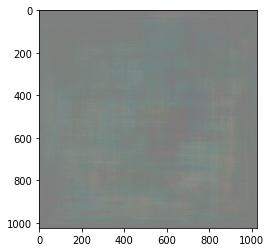

In [6]:
imshow(clip(imgs[-1][0]*127.5 + 127.5, 0, 255).astype('uint8'), aspect='equal')

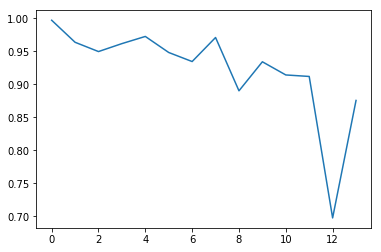

In [8]:
plot(gradp)

In [4]:
imagefile = glob.glob('/data/datasets/Hi_res_stills/Underwater/*')[-1]
print(imagefile)
x = imread(imagefile)[1000:5000, 1000:5000]
#figure(figsize=(20, 20))
#imshow(x, aspect='equal')
x = x.astype(float)
x /= 127.5
x -= 1

/data/datasets/Hi_res_stills/Underwater/Underwater_001.jpg


In [ ]:
tf.tile(tf.reshape(tf.range(6), (3, 2)), [2,1])

In [ ]:
list(reversed([1024, 512, 256, 128, 64, 32, 16, 8, 4]))

In [7]:
imgs[-1]

array([[[[  4.23380698e-04,  -1.09127874e-03,  -1.86710095e-04],
         [  1.10729667e-03,  -5.22851653e-04,  -1.07447566e-04],
         [  4.68749349e-04,  -1.80765230e-03,   1.83798329e-04],
         ..., 
         [  5.78968739e-03,   2.17005285e-03,  -2.15878151e-03],
         [  3.62878782e-03,   4.75076922e-05,  -3.04534519e-03],
         [ -9.87167121e-04,   1.82289793e-03,  -1.28090102e-03]],

        [[  2.72954302e-03,  -6.36643381e-05,  -1.04306273e-04],
         [  1.44554430e-03,  -2.71496107e-03,  -2.03334633e-03],
         [ -9.33923526e-04,  -3.18489014e-03,  -1.22425274e-03],
         ..., 
         [  5.88346180e-03,   2.21902621e-03,   4.06631222e-03],
         [  2.55064364e-03,   1.44816667e-03,   7.47170416e-04],
         [  8.26048839e-04,   6.84321159e-03,   2.16968372e-04]],

        [[  3.43403639e-03,  -1.12762814e-03,  -3.92957183e-04],
         [  3.23367817e-03,   2.56545551e-04,   8.77786486e-04],
         [  4.15216107e-03,   1.40210125e-03,  -3.606803